## Grid Search

In [108]:
import numpy as np
import pandas as pd
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import plotly.express as px

In [2]:
dataset = fetch_california_housing()

In [5]:
print(dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [10]:
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
# モデル
lgbmr = lgb.LGBMRegressor(random_state=0)
param_grid = {'num_leaves': [10, 20, 30, 40, 50, 60],
              'max_depth': [5, 10, 15],
              'reg_alpha': [0, 0.01, 0.03]}
cv = KFold(n_splits=3, random_state=0, shuffle=True)
gs = GridSearchCV(lgbmr, param_grid=param_grid, cv=cv)

In [30]:
# early_stopping
callbacks = [lgb.early_stopping(stopping_rounds=10)]
eval_set = [(X_val, y_val)]
fit_params = {'callbacks': callbacks, 'eval_set': eval_set}
gs.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.264841
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.255538
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.255538
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.240402
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.240164
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.240164
Did not meet ea

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, 15],
                         'num_leaves': [10, 20, 30, 40, 50, 60],
                         'reg_alpha': [0, 0.01, 0.03]})

In [21]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.223933,0.225003,0.013757,0.000292,5,10,0,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.797096,0.807785,0.805461,0.803448,0.004590,54
1,0.072422,0.008640,0.013764,0.000347,5,10,0.01,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.798894,0.806981,0.806050,0.803975,0.003613,53
2,0.074994,0.003492,0.013673,0.000204,5,10,0.03,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.799277,0.806364,0.806658,0.804100,0.003413,52
3,0.085039,0.010063,0.017791,0.001822,5,20,0,"{'max_depth': 5, 'num_leaves': 20, 'reg_alpha'...",0.811435,0.821243,0.815893,0.816190,0.004010,36
4,0.103134,0.017353,0.017834,0.001631,5,20,0.01,"{'max_depth': 5, 'num_leaves': 20, 'reg_alpha'...",0.810028,0.821356,0.813901,0.815095,0.004701,45


In [23]:
for index, row in cv_results_df[cv_results_df['rank_test_score']<=5].iterrows():
    print(f'{row["rank_test_score"]}: {row["params"]}')
    print(f'{row["mean_test_score"]}')

4: {'max_depth': 10, 'num_leaves': 50, 'reg_alpha': 0.01}
0.8329725903236045
3: {'max_depth': 15, 'num_leaves': 50, 'reg_alpha': 0}
0.8331058990226472
2: {'max_depth': 15, 'num_leaves': 50, 'reg_alpha': 0.03}
0.8332059773155042
5: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0}
0.8327661059213919
1: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0.01}
0.8338051795879502


In [31]:
lgbmr = lgb.LGBMRegressor(**gs.best_params_, random_state=0, learning_rate=0.01, n_estimators=1000)
callbacks = [lgb.early_stopping(stopping_rounds=10)]
eval_set = [(X_val, y_val)]
fit_params = {'callbacks': callbacks, 'eval_set': eval_set}
lgbmr.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.195693


LGBMRegressor(learning_rate=0.01, max_depth=15, n_estimators=1000,
              num_leaves=60, random_state=0, reg_alpha=0.01)

In [32]:
lgbmr.score(X_val, y_val)

0.8499232425233268

## Pipeline + Grid Search

In [46]:
df = pd.read_csv('penguins_size.csv')
# データクリーニング
df.loc[df[df['sex']=='.'].index[0], 'sex'] = np.nan
df.dropna(thresh=3, inplace=True)

In [47]:
X = df.drop('species', axis=1)
y = df['species']

In [64]:
# 欠損値代入、カテゴリカルカラムのエンコーディング

# 欠損値代入
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
imputer = SimpleImputer(strategy='most_frequent')
ct = ColumnTransformer([('cat_imputer', imputer, cat_cols)], remainder='passthrough')
ct.set_output(transform='pandas')

# OHE
class GetDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)

# モデル
lgbmc = lgb.LGBMClassifier(random_state=0)
    
# pipeline
pipeline = Pipeline([('impute', ct), ('dummy', GetDummies()), ('model', lgbmc)])

# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)
           
# grid serch    
param_grid = {'model__num_leaves': [10, 20, 30, 40, 50, 60],
              'model__max_depth': [5, 10, 15],
              'model__reg_alpha': [0, 0.01, 0.03]}
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('impute',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_imputer',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['island',
                                                                          'sex'])])),
                                       ('dummy', GetDummies()),
                                       ('model',
                                        LGBMClassifier(random_state=0))]),
             param_grid={'model__max_depth': [5, 10, 15],
                         'model__num_leaves': [10, 20, 30, 40, 50, 60],
                         'model__reg_alpha': [0, 0.01, 0.03]})

In [88]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__num_leaves,param_model__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.150501,0.080220,0.045536,0.052863,5,10,0,"{'model__max_depth': 5, 'model__num_leaves': 1...",0.991228,0.982456,0.991228,0.988304,0.004135,1
1,0.030379,0.002513,0.007982,0.001274,5,10,0.01,"{'model__max_depth': 5, 'model__num_leaves': 1...",0.991228,0.991228,0.973684,0.985380,0.008270,19
2,0.028574,0.002153,0.007586,0.000120,5,10,0.03,"{'model__max_depth': 5, 'model__num_leaves': 1...",0.991228,0.991228,0.973684,0.985380,0.008270,19


## Random Seach CV

In [76]:
# データ準備
dataset = fetch_california_housing()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# モデル
lgbmr = lgb.LGBMRegressor(random_state=0)
param_dist = {'num_leaves': sp_randint(10, 60),
              'max_depth': sp_randint(5, 15),
              'reg_alpha': uniform(0, 0.03)}

eval_set = [(X_val, y_val)]
callbacks = [lgb.early_stopping(stopping_rounds=10)]
fit_params = {"callbacks": callbacks, "eval_set": eval_set}


# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)

#grid search
rs = RandomizedSearchCV(lgbmr, param_distributions=param_dist, cv=cv, n_iter=36)
rs.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.245908
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.240318
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.240318
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.225217
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.220163
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.220163
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.220163
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.220163
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.220163
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.21858
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.217419
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.215572
Did not meet early 

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=LGBMRegressor(random_state=0), n_iter=36,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3424fd1100>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3425914f10>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3424fe66a0>})

In [79]:
cv_results_df = pd.DataFrame(rs.cv_results_)
cv_results_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.218127,0.175964,0.018183,0.001082,5,19,0.01459,"{'max_depth': 5, 'num_leaves': 19, 'reg_alpha'...",0.808572,0.820177,0.813661,0.814136,0.004750,35
1,0.152993,0.007973,0.026096,0.001798,7,43,0.007195,"{'max_depth': 7, 'num_leaves': 43, 'reg_alpha'...",0.824776,0.832492,0.825335,0.827534,0.003513,16
2,0.153368,0.034681,0.019494,0.000810,12,17,0.013745,"{'max_depth': 12, 'num_leaves': 17, 'reg_alpha...",0.813781,0.824065,0.820397,0.819414,0.004255,29


In [86]:
for _, row in cv_results_df[cv_results_df['rank_test_score']<=5].iterrows():
    print(f"{row['rank_test_score']}: {row['params']}")
    print(f"{row['mean_test_score']}")

4: {'max_depth': 12, 'num_leaves': 53, 'reg_alpha': 0.007902855264737123}
0.8324776042420571
1: {'max_depth': 11, 'num_leaves': 58, 'reg_alpha': 0.02472029102585988}
0.8339726419743805
2: {'max_depth': 13, 'num_leaves': 57, 'reg_alpha': 0.007621712836729934}
0.8329092315758252
5: {'max_depth': 11, 'num_leaves': 54, 'reg_alpha': 0.029751738423946208}
0.8320553106668923
3: {'max_depth': 11, 'num_leaves': 51, 'reg_alpha': 0.01863977009812156}
0.832513914456621


In [87]:
rs.best_params_

{'max_depth': 11, 'num_leaves': 58, 'reg_alpha': 0.02472029102585988}

## ベイズ最適化

In [101]:
# データ準備
dataset = fetch_california_housing()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

# 関数
def objective(params):
    params = {'num_leaves': int(params['num_leaves']),
         'max_depth': int(params['max_depth']),
         'reg_alpha': params['reg_alpha']}
    model = lgb.LGBMRegressor(**params, random_state=0)
    cv = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv)
    
    log['params'].append(params)
    log['score'].append(scores.mean())
    log['score_std'].append(scores.std())
    
    return -scores.mean()

space = {'num_leaves': hp.quniform('num_leaves', 10, 60, 2),
         'max_depth': hp.quniform('max_depth',5 , 15, 2),
         'reg_alpha': hp.uniform('reg_alpha', 0, 0.03)}

log = {'params': [], 'score': [], 'score_std': []}
best = fmin(objective, space=space, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [00:53<00:00,  1.86trial/s, best loss: -0.8416432410129646]


In [105]:
log_df = pd.DataFrame(log)
log_df = log_df.sort_values('score', ascending=False)

In [106]:
log_df[['num_leaves', 'max_depth', 'reg_alpha']] = log_df.apply(lambda row: pd.Series(row['params']), axis=1)

In [107]:
log_df

,params,score,score_std,num_leaves,max_depth,reg_alpha
21,"{'num_leaves': 60, 'max_depth': 12, 'reg_alpha...",0.841643,0.003260,60.0,12.0,0.015680
24,"{'num_leaves': 60, 'max_depth': 12, 'reg_alpha...",0.840989,0.003371,60.0,12.0,0.014186
74,"{'num_leaves': 60, 'max_depth': 12, 'reg_alpha...",0.840954,0.002792,60.0,12.0,0.019557
65,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.840921,0.003688,60.0,14.0,0.014357
70,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.840921,0.003688,60.0,14.0,0.014413
...,...,...,...,...,...,...
47,"{'num_leaves': 16, 'max_depth': 10, 'reg_alpha...",0.821618,0.004693,16.0,10.0,0.025053
13,"{'num_leaves': 14, 'max_depth': 10, 'reg_alpha...",0.818625,0.003731,14.0,10.0,0.023560
18,"{'num_leaves': 12, 'max_depth': 8, 'reg_alpha'...",0.814415,0.003979,12.0,8.0,0.000931
87,"{'num_leaves': 12, 'max_depth': 12, 'reg_alpha...",0.813853,0.003355,12.0,12.0,0.022088


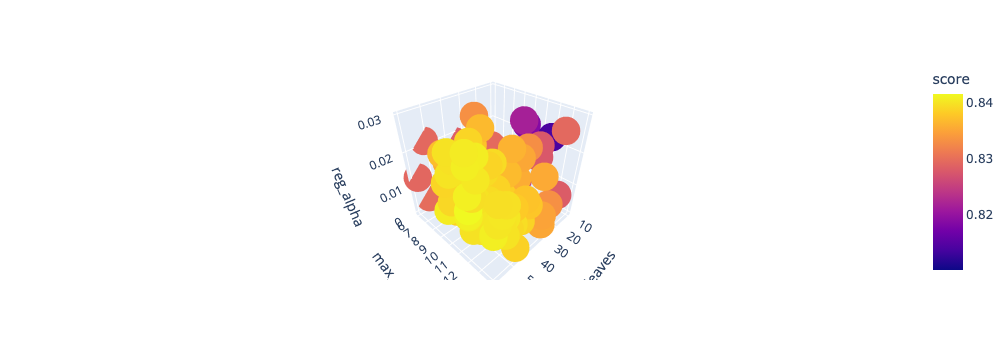

In [111]:
# 描画
fig = px.scatter_3d(log_df, x='num_leaves', y='max_depth', z='reg_alpha', color='score')
fig.show()